# Analyzing radial velocity timeseries
## DACE - python APIs

## Author
Jean-Baptiste Delisle (DACE data scientist)

## Goals
1. Use DACE APIs to download radial velocity timeseries
2. Visualize and analyze it (periodograms, fit, MCMC, etc.)

## Topics
1. Packages installation with **pip install**
2. Downloading radial velocity timeseries using DACE APIs
3. Defining a model
4. Looking for planetary signals using a periodogram (+ FAP) approach
5. Fitting model parameters
6. Launching a MCMC (samsam)

## Requirements
python 3, matplotlib, numpy, scipy, astroquery  
**python-dace-client, kepmodel, samsam, corner** (see below for installation instructions)

## Summary
This tutorial demonstrates the use of the python DACE APIs and associated packages
to download, visualize and analyze radial velocity timeseries.

## Packages installation

**Install DACE APIs** (see also [DACE APIs installation tutorial](https://dace.unige.ch/tutorials/?tutorialId=10)):  
`pip install python-dace-client`

**Install kepmodel**:  
`pip install --extra-index-url https://obswww.unige.ch/~delisle kepmodel`

**Install samsam**:  
`pip install --extra-index-url https://obswww.unige.ch/~delisle samsam`

**Install corner**:  
`pip install corner`

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dace.spectroscopy import Spectroscopy
from astroquery.simbad import Simbad
from kepmodel import rv, tools
from spleaf import term
from samsam import sam, logprior, acf
import corner

2021-04-01 14:10:23,214 - WARNING - No .dacerc file found. You are requesting data in public mode. If you need to be connected, please create a .dacerc file in your home directory containing your api key. See README for details.


## Settings

In [2]:
# Data settings
target = 'HD 51608'

# Instruments
instruments = [] # By default select all available instruments
inst_sec_acc = {} # Keep default settings for secular correction for each instrument
inst_jitter = {} # Keep default settings for instruments jitter
epoch_rjd = 55500

# drift power
dpow = 0

# Detrending
indicators = ['rhk']
indic_kernel_smoother = [tools.gaussian_kernel]
indic_filter_timescale_yr = [0.5]
indic_filter_type = ['low']

# Periodogram settings
Pmin = 0.8
Pmax = 10000
nfreq = 100000
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)

# Planet detection settings
fap_max = 1e-3
max_pla = 5

# Fit options
# WARNING: the fit algorithm has not been extensively tested.
# There is room for improvements
# (better choice of minimization algorithm and/or options, ...)
fit_method = 'L-BFGS-B'
fit_options = {
    'maxiter': 1000,
    'maxcor': 50
}
start_fit_jitter_at_step = 0
fit_ecc = True

# MCMC options
nsamples = 100000

## Load data

In [3]:
# Download data
rv_data = Spectroscopy.get_timeseries(target, sorted_by_instrument=False)
nt = len(rv_data['rjd'])
# Convert to numpy arrays
for key in rv_data:
    try:
        if key == 'drs_qc':
            rv_data[key] = np.array(rv_data[key], dtype=bool)
        else:
            rv_data[key] = np.array(rv_data[key], dtype=float)
    except:
        rv_data[key] = np.array(rv_data[key])
        pass
print('Number of points before cleaning:', nt)

# DRS quality check + nans
for key in rv_data:
    if rv_data[key].dtype == float:
        rv_data[key][rv_data[key]==-99999] = np.nan
keep_crit = rv_data['drs_qc']
for key in ['rv', 'rv_err'] + indicators:
    keep_crit = keep_crit & (rv_data[key] == rv_data[key])
# Instruments
if instruments:
    in_inst_list = False
    for inst in instruments:
        in_inst_list = in_inst_list | (rv_data['ins_name'] == inst)
    keep_crit = keep_crit & in_inst_list
# Apply filtering
for key in rv_data:
    if len(rv_data[key]) == nt:
        rv_data[key] = rv_data[key][keep_crit]

# Remove empty instruments
instruments = np.unique(rv_data['ins_name'])
ninst = len(instruments)

# Sort by increasing time
ksort = np.argsort(rv_data['rjd'])
for key in rv_data:
    rv_data[key] = rv_data[key][ksort]

nt = rv_data['rjd'].size
print('Number of points after cleaning:', nt)
print('\nList of instruments kept after cleaning:')
print(instruments)
print('\nList of available fields:')
print(rv_data.keys())

Number of points before cleaning: 216
Number of points after cleaning: 216

List of instruments kept after cleaning:
['HARPS03']

List of available fields:
dict_keys(['berv', 'berv_err', 'bispan', 'bispan_err', 'drift_noise', 'drift_noise_err', 'texp', 'texp_err', 'cal_therror', 'cal_therror_err', 'fwhm', 'fwhm_err', 'protm08', 'protm08_err', 'protn84', 'protn84_err', 'public', 'spectroFluxSn20', 'spectroFluxSn20_err', 'ins_mode', 'rhk', 'rhk_err', 'ins_name', 'mask', 'raw_file', 'contrast', 'contrast_err', 'cal_thfile', 'spectroFluxSn50', 'spectroFluxSn50_err', 'naindex', 'naindex_err', 'snca2', 'snca2_err', 'pub_reference', 'pub_bibcode', 'sindex', 'sindex_err', 'drs_qc', 'haindex', 'haindex_err', 'drs_version', 'caindex', 'caindex_err', 'rjd', 'rjd_err', 'rv', 'rv_err', 'ccf_noise', 'ccf_noise_err', 'drift_used', 'drift_used_err', 'ccf_asym', 'ccf_asym_err', 'date_night'])


## Secular correction

In [4]:
default_inst_sec_acc = {
  'CORALIE98': True,
  'CORALIE07': True,
  'CORALIE14': True,
  'CORAVEL': True,
  'HARPS03': True,
  'HARPS15': True,
  'HARPN': True,
  'HIRES': False,
  'UCLES': False,
  'ESPRESSO': True,
  'SOPHIE': True,
  'ELODIE': True,
  'default': False
}

# Query Simbad for parallax and proper motion
simb = Simbad()
simb.reset_votable_fields()
simb.add_votable_fields('plx', 'pmra', 'pmdec')
target_info = simb.query_object(target)
plx_mas = target_info['PLX_VALUE'] # 28.497400
pmra_mas_yr = target_info['PMRA'] # -27.951
pmdec_mas_yr = target_info['PMDEC'] # -160.436

# Compute secular acceleration
d_m = 1000.0 / plx_mas * 3.08567758e16
mu_rad_s = np.sqrt(pmra_mas_yr * pmra_mas_yr + pmdec_mas_yr *
    pmdec_mas_yr) * 2 * np.pi / (360.0 * 1000.0 * 3600.0 * 86400.0 * 365.25)
secacc = d_m * mu_rad_s * mu_rad_s * 86400.0
for inst in instruments:
    if inst in inst_sec_acc:
        apply_sec = inst_sec_acc[inst]
    elif inst in default_inst_sec_acc:
        apply_sec = default_inst_sec_acc[inst]
    else:
        apply_sec = default_inst_sec_acc['default']
    if apply_sec:
        kinst = rv_data['ins_name']==inst
        rv_data['rv'][kinst] -= (rv_data['rjd'][kinst] - epoch_rjd) * secacc

## Initialize model

In [5]:
default_inst_jitter = {
  'CORALIE98': 5.0,
  'CORALIE07': 8.0,
  'CORALIE14': 3.0,
  'CORAVEL': 150.0,
  'HARPS03': 0.75,
  'HARPS15': 0.75,
  'HARPN': 0.75,
  'HIRES': 2.5,
  'UCLES': 7.0,
  'ESPRESSO': 0.05,
  'SOPHIE': 1.5,
  'ELODIE': 12.0,
  'default': 0.0
}

instjit = {}
for inst in instruments:
    if inst in inst_jitter:
        sig = inst_jitter[inst]
    elif inst in default_inst_jitter:
        sig = default_inst_jitter[inst]
    else:
        sig = default_inst_jitter['default']
    instjit[f'inst_jit_{inst}'] = term.InstrumentJitter(rv_data['ins_name']==inst, sig)

rv_model = rv.RvModel(
    rv_data['rjd']-epoch_rjd,
    rv_data['rv'],
    err = term.Error(rv_data['rv_err']),
    **instjit)

## Plot timeseries

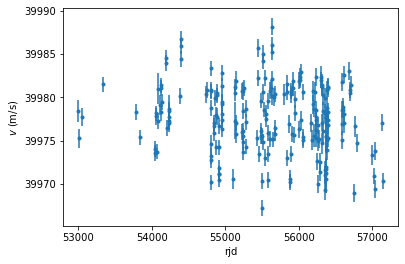

In [6]:
rv_err = np.sqrt(rv_model.cov.A)
plt.figure()
for inst in instruments:
    kinst = rv_data['ins_name']==inst
    plt.errorbar(
        rv_data['rjd'][kinst],
        rv_data['rv'][kinst],
        yerr=rv_err[kinst],
        fmt='.', rasterized=True)
plt.xlabel('rjd')
plt.ylabel('$v$ (m/s)')
plt.show()
plt.close()

## Linear parameters

Plot activity indicator: rhk_low


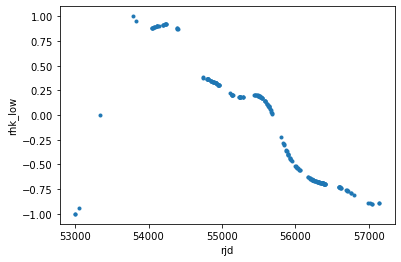

Fit linear parameters:
Parameter                        Value     Error       
lin.offset_inst_HARPS03     39977.6668  ±  0.0674      
lin.rhk_low                      1.010  ±  0.120       

loglikelihood = -1893.0651260020013


In [7]:
# Add linear parameters
for inst in instruments:
    rv_model.add_lin(1.0*(rv_data['ins_name']==inst), f'offset_inst_{inst}')
for kpow in range(dpow):
    rv_model.add_lin(rv_model.t**(kpow+1), f'drift_pow{kpow+1}')
for kind, indic in enumerate(indicators):
    tmp = rv_data[indic].copy()
    if indic_kernel_smoother[kind] is not None:
        tau = 365.25*indic_filter_timescale_yr[kind]
        tmp_smooth = tools.smooth_timeseries(
            rv_data['rjd'],
            tmp,
            indic_kernel_smoother[kind], tau)
        if indic_filter_type[kind] == 'high':
            tmp -= tmp_smooth
        else:
            tmp = tmp_smooth
    tmpmx = tmp.max()
    tmpmn = tmp.min()
    tmp = 2.0*(tmp-tmpmn)/(tmpmx-tmpmn) - 1.0
    indic_name = indic
    if indic_filter_type[kind] is not None:
        indic_name += "_" + indic_filter_type[kind]
    rv_model.add_lin(tmp, indic_name)
    print('Plot activity indicator: {}'.format(indic_name))
    plt.figure()
    for inst in instruments:
        kinst = rv_data['ins_name']==inst
        plt.plot(rv_data['rjd'][kinst],
                 tmp[kinst],
                 '.', rasterized=True)
    plt.xlabel('rjd')
    plt.ylabel(indic_name)
    plt.show()
    plt.close()    
print("Fit linear parameters:")
rv_model.fit(method=fit_method, options=fit_options)
rv_model.show_param()
print('loglikelihood =', rv_model.loglike())

## Fit instruments jitter

In [8]:
jitter_params = [f'cov.{key}.sig' for key in instjit]
if start_fit_jitter_at_step == 0:
    rv_model.fit_param += jitter_params
    rv_model.fit(method=fit_method,options=fit_options)
    rv_model.show_param()
    print('loglikelihood =', rv_model.loglike())

Parameter                        Value     Error       
lin.offset_inst_HARPS03      39977.694  ±  0.267       
lin.rhk_low                      1.153  ±  0.465       
cov.inst_jit_HARPS03.sig         3.803  ±  0.188       

loglikelihood = -598.3356749516573


## Search for planets iteratively

Plot residuals:


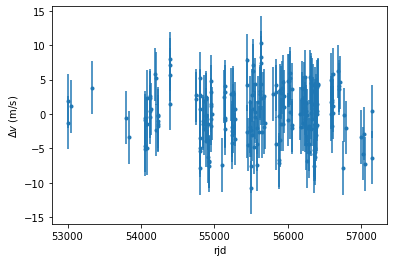

Periodogram of residuals:


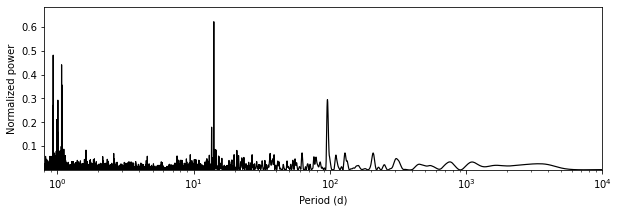

Highest periodogram peak:
P=14.07310335382013 d, power=0.6211553267967848, FAP=1.7035244720686715e-40

Fit all parameters:
Parameter                        Value     Error       
lin.offset_inst_HARPS03      39977.630  ±  0.164       
lin.rhk_low                      1.325  ±  0.289       
cov.inst_jit_HARPS03.sig         2.273  ±  0.118       
kep.0.P                       14.07343  ±  0.00215     
kep.0.la0 [deg]                 256.92  ±  3.04        
kep.0.K                          4.384  ±  0.233       
kep.0.ecosw                    -0.0495  ±  0.0525      
kep.0.esinw                     0.0501  ±  0.0552      

loglikelihood = -492.8681800361411

Plot residuals:


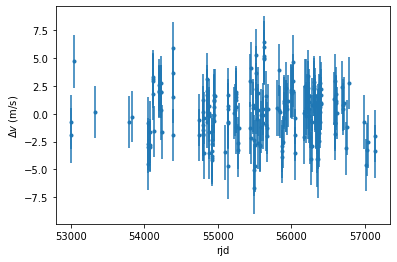

Periodogram of residuals:


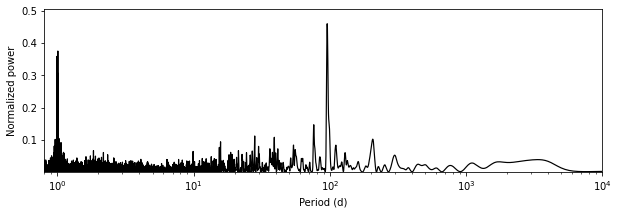

Highest periodogram peak:
P=95.70041489415763 d, power=0.45970820853862016, FAP=2.252108142918537e-24

Fit all parameters:
Parameter                        Value     Error       
lin.offset_inst_HARPS03      39977.327  ±  0.123       
lin.rhk_low                      1.267  ±  0.213       
cov.inst_jit_HARPS03.sig        1.5618  ±  0.0877      
kep.0.P                       14.07213  ±  0.00158     
kep.0.la0 [deg]                 255.19  ±  2.38        
kep.0.K                          4.036  ±  0.170       
kep.0.ecosw                    -0.0450  ±  0.0421      
kep.0.esinw                     0.0886  ±  0.0410      
kep.1.P                         95.732  ±  0.114       
kep.1.la0 [deg]                 199.81  ±  3.99        
kep.1.K                          2.542  ±  0.199       
kep.1.ecosw                    -0.1566  ±  0.0692      
kep.1.esinw                    -0.1043  ±  0.0690      

loglikelihood = -420.7759266572975

Plot residuals:


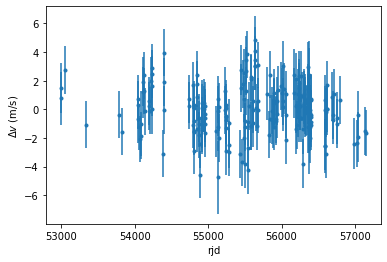

Periodogram of residuals:


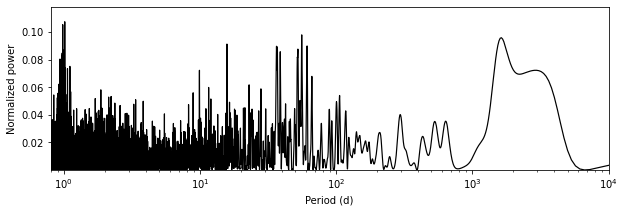

Highest periodogram peak:
P=1.016628332448231 d, power=0.1075814034347391, FAP=0.0797096627834687

Stopping here (non-significant detection)


In [9]:
for _ in range(max_pla):
    # Plot residuals
    print('Plot residuals:')
    res = rv_model.residuals()
    rv_err = np.sqrt(rv_model.cov.A)
    plt.figure()
    for inst in instruments:
        kinst = rv_data['ins_name']==inst
        plt.errorbar(
            rv_data['rjd'][kinst],
            res[kinst],
            yerr=rv_err[kinst],
            fmt='.', rasterized=True)
    plt.xlabel('rjd')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()
    # Compute periodogram
    print('Periodogram of residuals:')
    nu, power = rv_model.periodogram(nu0, dnu, nfreq)
    P = 2 * np.pi / nu
    # Compute FAP
    kmax = np.argmax(power)
    faplvl = rv_model.fap(power[kmax], nu.max())
    # Plot periodogram
    plt.figure(figsize=(10, 3))
    plt.plot(P, power, 'k', lw=1.2, rasterized=True)
    plt.xlim(Pmin, Pmax)
    plt.ylim(power.min(), 1.1 * power.max())
    plt.xscale('log')
    plt.xlabel('Period (d)')
    plt.ylabel('Normalized power')
    plt.show()
    plt.close()
    # Show results
    print('Highest periodogram peak:')
    print('P={} d, power={}, FAP={}\n'.format(P[kmax], power[kmax], faplvl))
    if faplvl > fap_max:
        print('Stopping here (non-significant detection)')
        break    
    print('Fit all parameters:')
    # Add new planet
    rv_model.add_keplerian_from_period(P[kmax])
    rv_model.set_keplerian_param(f'{rv_model.nkep-1}', param=['P', 'la0', 'K', 'ecosw', 'esinw'])
    if not fit_ecc:
        rv_model.set_param(np.zeros(2), rv_model.fit_param[-2:])
        rv_model.fit_param = rv_model.fit_param[:-2]
    # Add jitter to fit_param if needed
    if rv_model.nkep == start_fit_jitter_at_step:
        rv_model.fit(method=fit_method, options=fit_options)
        rv_model.fit_param += jitter_params
    # Global fit of the model
    rv_model.fit(method=fit_method, options=fit_options)
    rv_model.show_param()
    print('loglikelihood = {}\n'.format(rv_model.loglike()))

## Phase folding

Planet 0 (14.072 d)


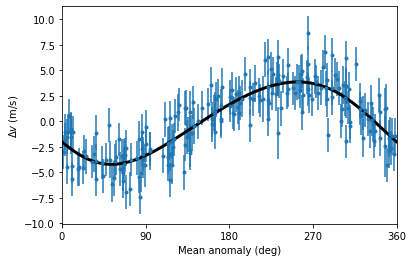

Planet 1 (95.732 d)


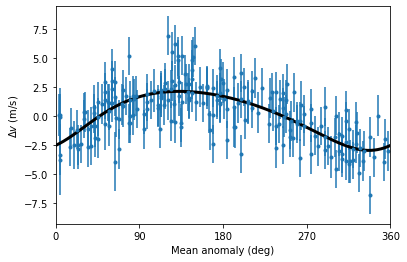

In [10]:
res = rv_model.residuals()
rv_err = np.sqrt(rv_model.cov.A)
for name in rv_model.keplerian:
    kep = rv_model.keplerian[name]
    param = kep.get_param()
    rv_model.set_keplerian_param(name, param=['n', 'M0', 'K', 'ecosw', 'esinw'])
    n = rv_model.get_param(f'kep.{name}.n')
    M0 = rv_model.get_param(f'kep.{name}.M0')
    rv_model.set_keplerian_param(name, param=param)
    M = (M0 + n*rv_model.t)*180/np.pi % 360
    Mmod = np.linspace(0,360,1000)
    tmod = (Mmod*np.pi/180-M0)/n
    print(f'Planet {name} ({2*np.pi/n:.3f} d)')
    plt.figure()
    plt.xlim(0,360)
    plt.xticks([0,90,180,270,360])
    plt.plot(Mmod, kep.rv(tmod), 'k', lw=3, rasterized=True)
    for inst in instruments:
        kinst = rv_data['ins_name']==inst
        plt.errorbar(
            M[kinst],
            (res+kep.rv(rv_model.t))[kinst],
            yerr=rv_err[kinst],
            fmt='.', rasterized=True)
    plt.xlabel('Mean anomaly (deg)')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()

## Launch MCMC

In [11]:
x_old = rv_model.get_param()
param = rv_model.fit_param
def lprior(x):
    lp = 0
    for par, val in zip(param, x):
        if '.sig' in par:
            lp += logprior.loguniform(val, np.log(1e-3), np.log(1e2))
        elif '.K' in par:
            lp += logprior.loguniform(val, np.log(0.1), np.log(1e5))
        elif '.P' in par:
            lp += logprior.loguniform(val, np.log(0.1), np.log(1e5))
        elif par.endswith('.e'):
            lp += logprior.beta(val, 0.867, 3.03)
        elif par.endswith('.ecosw'):
            parb = par.replace('.ecosw', '.esinw')
            valb = x[param.index(parb)]
            lp += logprior.modbeta(val, valb, 0.867, 3.03)
        # TODO : other parameters
    return(lp)
        
def lprob(x):
    try:
        lp = lprior(x)
        if not (lp > -np.inf):
            return (-np.inf)
        ll = rv_model.loglike(x, backup=False)
        if np.isnan(ll):
            return(-np.inf)
        return(lp + ll)
    except:
        return (-np.inf)

samples, diagnostics = sam(x_old, lprob, nsamples=nsamples)
rv_model.set_param(x_old)

Step 100000, acceptance rate (since last printing): 0.2260 


## Check convergence using ACF

maximum IAT: 54.67091040815502
effective number of samples: 1371.8630152683984


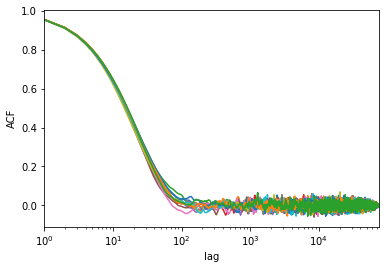

In [12]:
R = acf.acf(samples[nsamples//4:])
tau = np.arange(R.shape[0])
plt.figure()
plt.plot(tau[1:], R[1:])
plt.xscale('log')
plt.xlim(1, tau[-1])
plt.xlabel('lag')
plt.ylabel('ACF')
iat = np.max(acf.iat(R=R))
print('maximum IAT:', iat)
print('effective number of samples:', R.shape[0]/iat)

## Corner plot

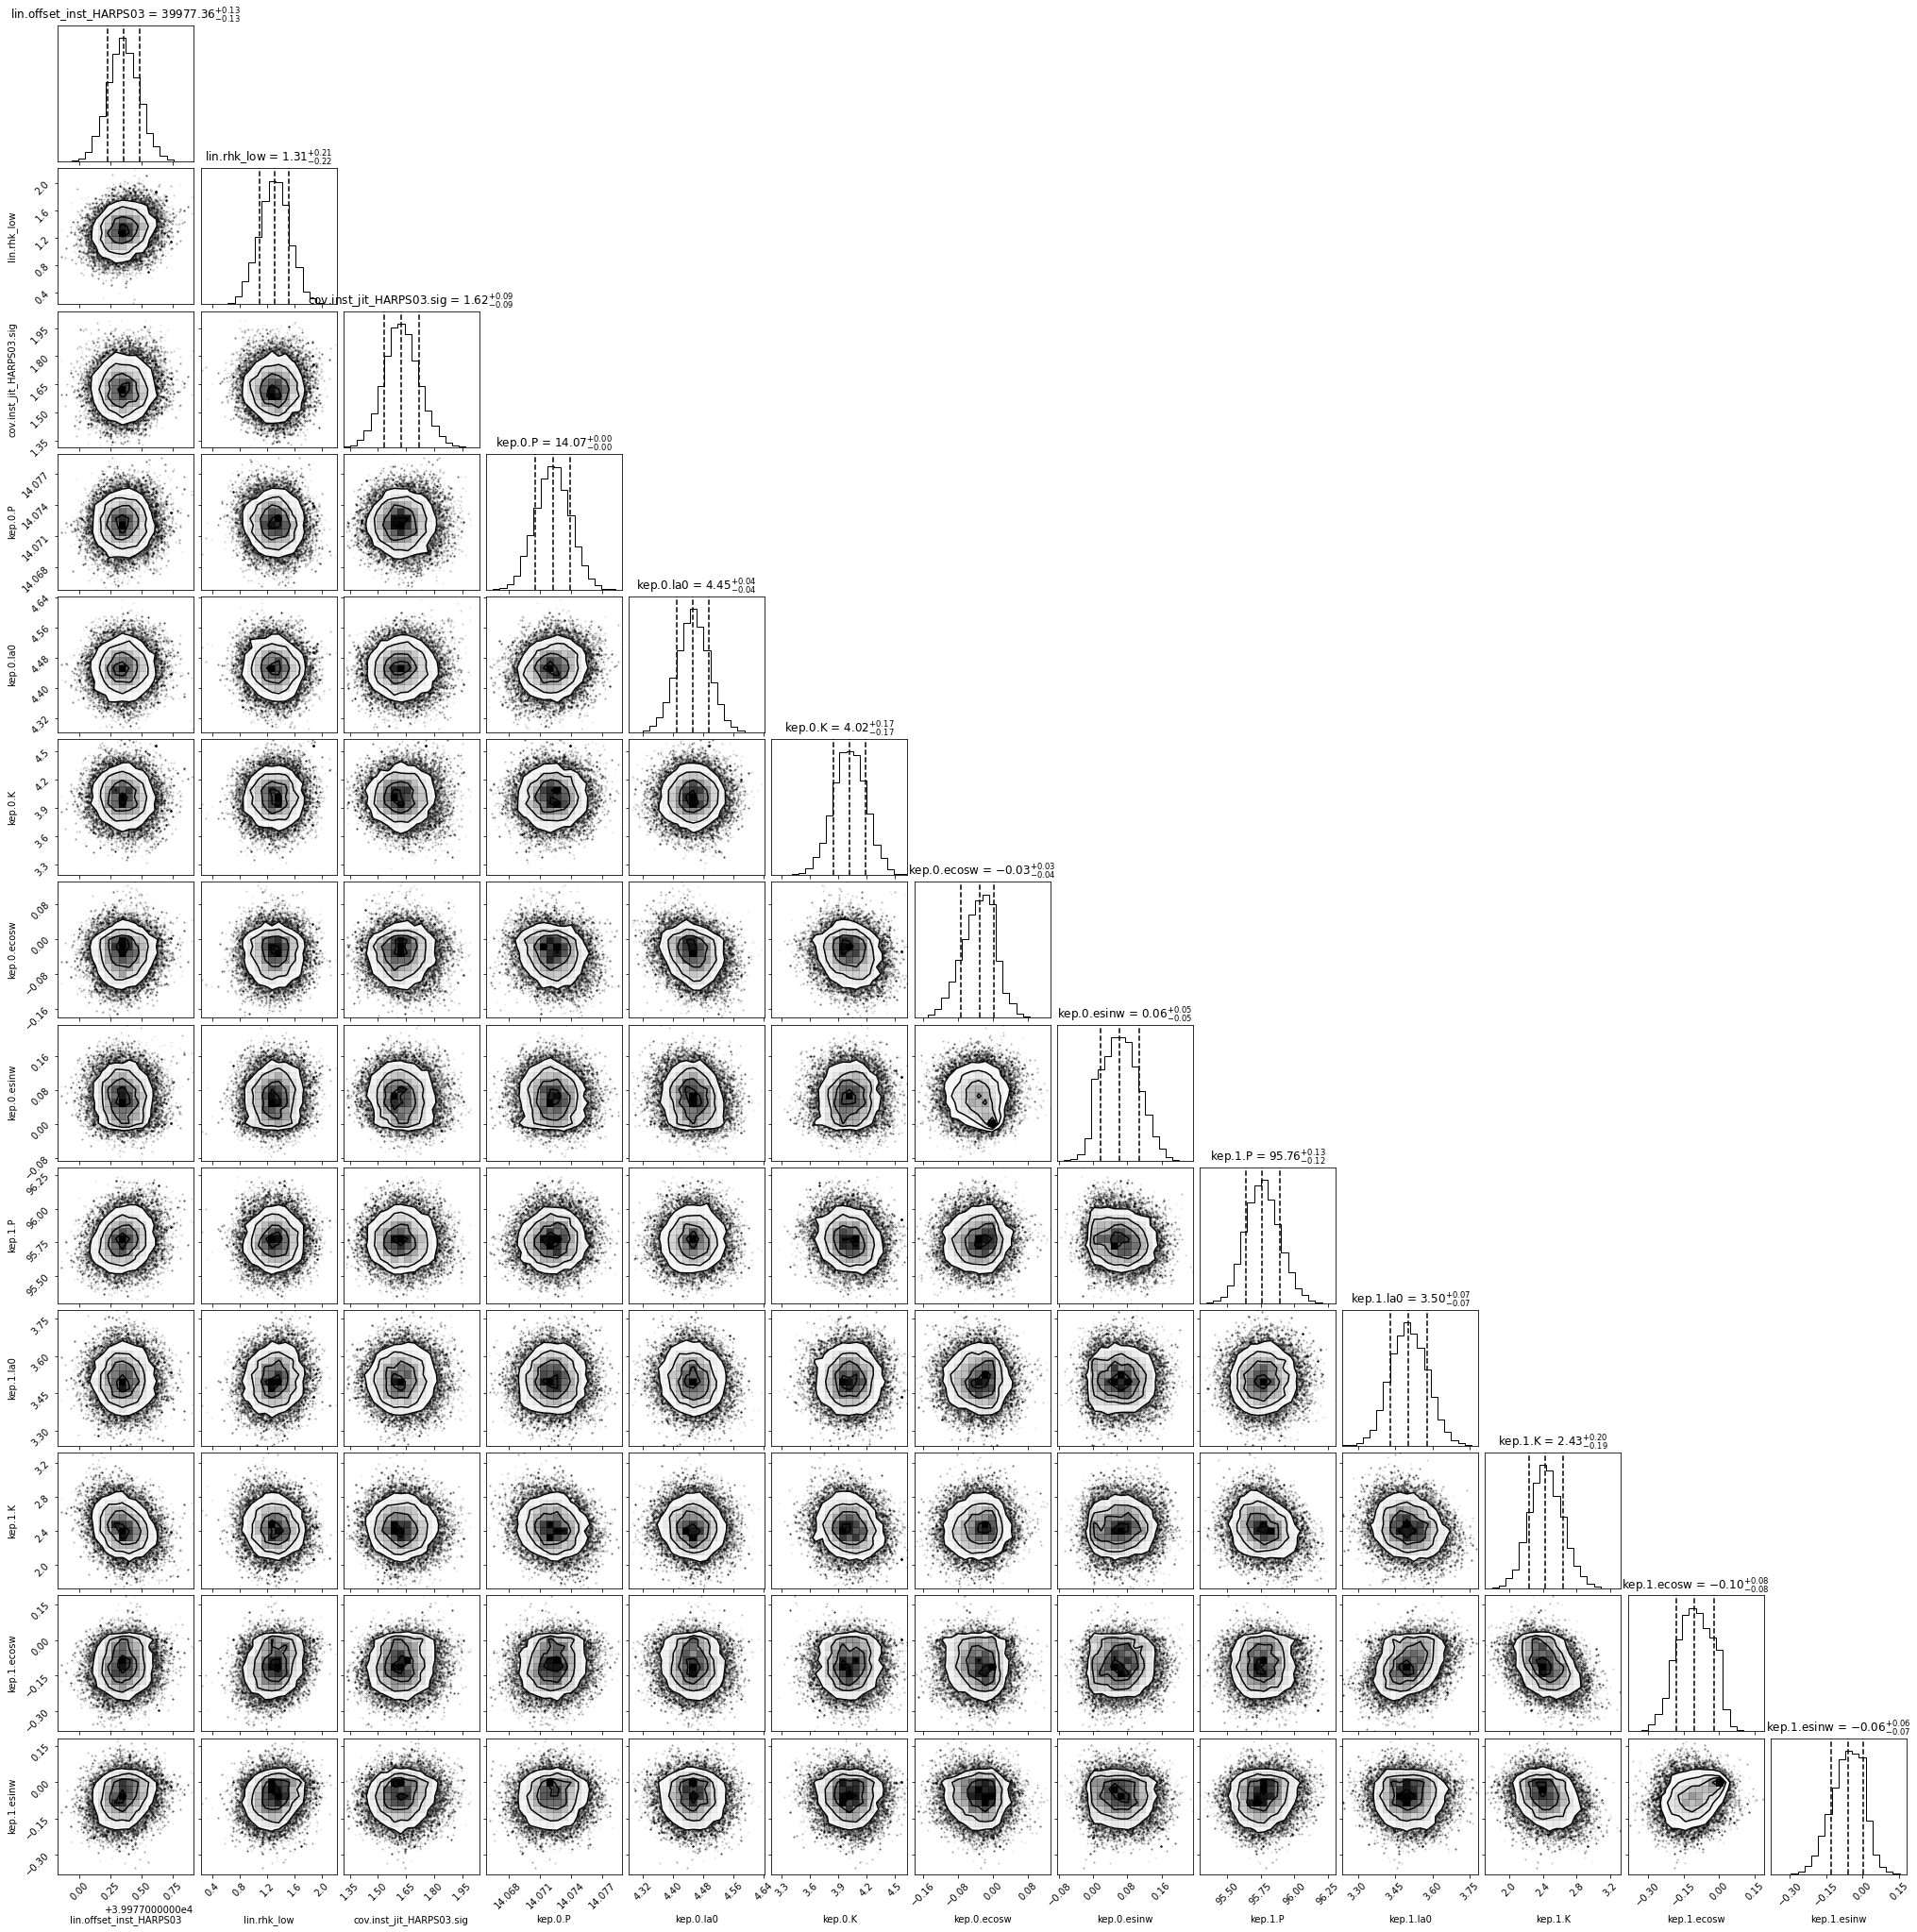

In [13]:
corner.corner(
    samples[nsamples//4:],
    labels=rv_model.fit_param,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True)
plt.show()
plt.close()